In [19]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
import time
import concurrent.futures
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import mplfinance as mpf
import plotly.graph_objects as go
import nbformat
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
pio.renderers.default = 'notebook'


In [20]:
STOP_LOSS = 0.02

# Load data module

In [35]:
# Data Loading and Cleaning
file_path = 'Data\Binance_BTCUSDT_2023_minute.csv'
df = pd.read_csv(file_path)
df = df.drop('unix', axis=1).drop('date', axis=1).drop('symbol', axis=1)
# df = df.drop('marketorder_volume_from', axis=1).drop('marketorder_volume', axis=1).drop('date_close', axis=1).drop('close_unix', axis=1) 
df = df.iloc[::-1].reset_index(drop=True)

# You might have additional preprocessing steps here.
# Example: Normalize data, handle missing values, etc.
# df = df[:43800]
df_natural = df  # Preserving the natural form of data if needed later


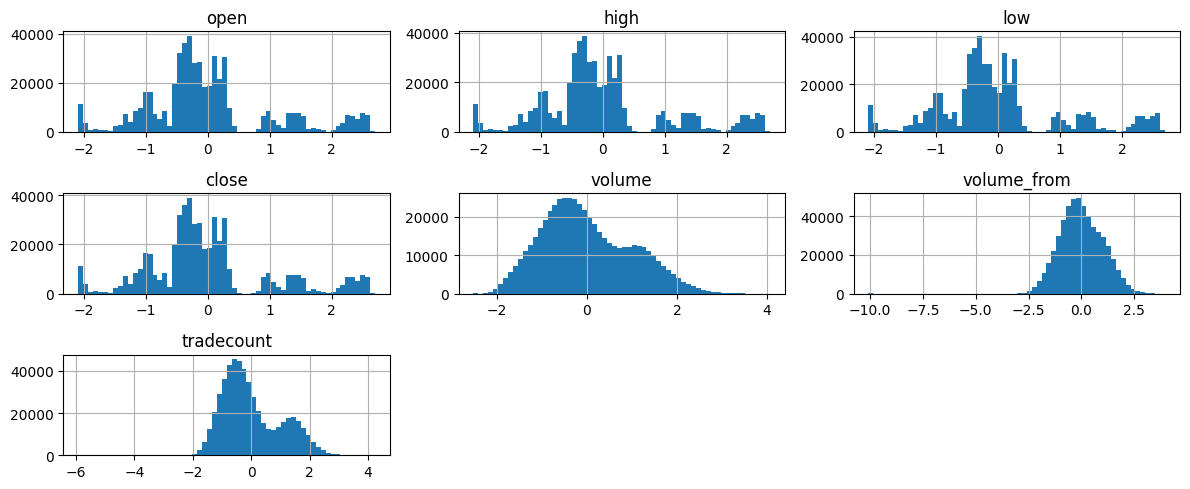

In [36]:
df['volume'] = np.log(df_natural['volume'] + 1)
df['volume_from'] = np.log(df_natural['volume_from'] + 1)
df['tradecount'] = np.log(df_natural['tradecount'] + 1)

scaler = StandardScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_data, columns= df.columns)


# Plotting the histograms for the log-transformed and normalized data
normalized_df.hist(figsize=(12, 5), bins=60)
plt.tight_layout()
plt.savefig(fname = "normalized_data.png")
plt.show()


In [37]:
normalized_df.describe()

,open,high,low,close,volume,volume_from,tradecount
count,5.255170e+05,5.255170e+05,5.255170e+05,5.255170e+05,5.255170e+05,5.255170e+05,5.255170e+05
mean,-1.124068e-15,7.961066e-16,5.313146e-16,1.213197e-15,6.572206e-16,-5.603033e-16,-1.251488e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.090640e+00,-2.091100e+00,-2.090955e+00,-2.090676e+00,-2.519940e+00,-1.008627e+01,-5.912194e+00
25%,-4.899169e-01,-4.901301e-01,-4.896886e-01,-4.899232e-01,-7.398307e-01,-6.975006e-01,-7.452217e-01
50%,-1.845420e-01,-1.841631e-01,-1.847298e-01,-1.845587e-01,-1.486857e-01,-5.768962e-02,-2.439618e-01
75%,2.519907e-01,2.512573e-01,2.527091e-01,2.519839e-01,7.198032e-01,7.059977e-01,6.919566e-01
max,2.700293e+00,2.700474e+00,2.693216e+00,2.700284e+00,4.065829e+00,3.971723e+00,4.237074e+00


In [1]:
# Assuming normalized_df is your DataFrame
normalized_df.describe()

# Save the description to a CSV file
# description.to_csv('description.csv', index=True)



NameError: name 'normalized_df' is not defined

In [45]:
normalized_df.head(10000).to_csv('normalized_data.csv', index=False)

In [ ]:
train_data = normalized_df[:int(0.8 * len(normalized_df))]
test_data = normalized_df[int(0.8 * len(normalized_df)):]

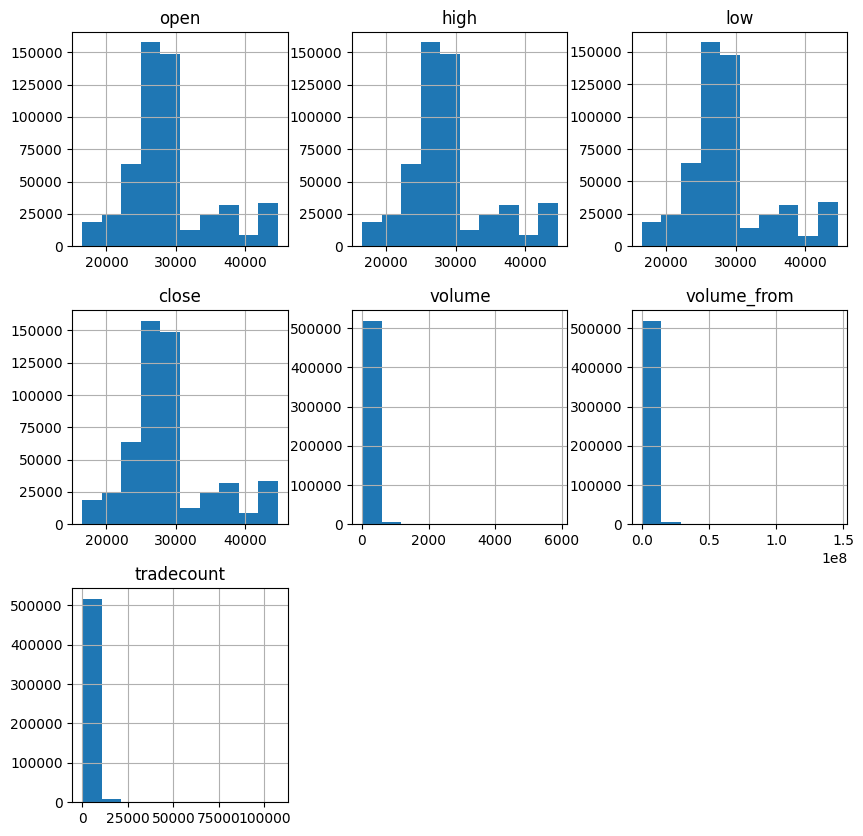

In [13]:
import matplotlib.pyplot as plt
df.hist(figsize=(10, 10))
plt.show()

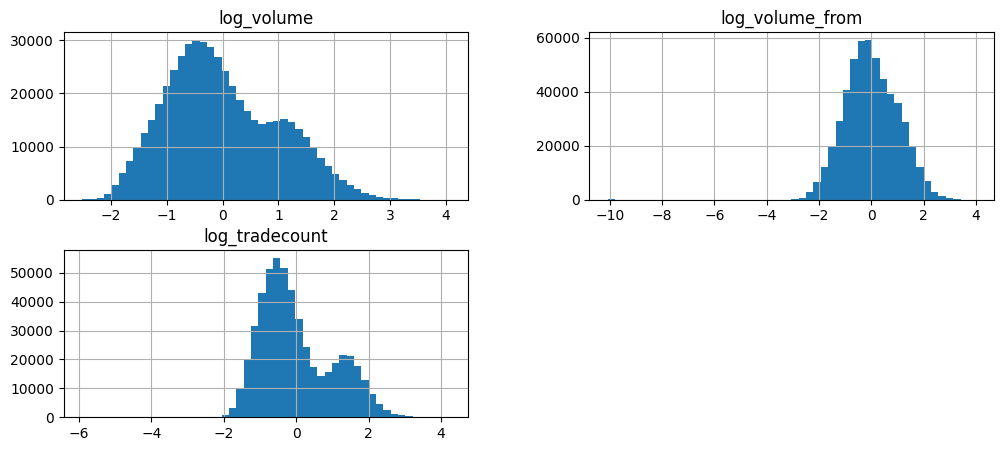

In [17]:
df['log_volume'] = np.log(df['volume'] + 1)
df['log_volume_from'] = np.log(df['volume_from'] + 1)
df['log_tradecount'] = np.log(df['tradecount'] + 1)

# Now plot the histograms for the log-transformed data

normalized_log_data = scaler.fit_transform(df[['log_volume', 'log_volume_from', 'log_tradecount']])
normalized_log_df = pd.DataFrame(normalized_log_data, columns= df[['log_volume', 'log_volume_from', 'log_tradecount']].columns)

normalized_log_df.hist(figsize=(12, 5), bins=50)
plt.show()

In [18]:
normalized_log_df.describe()


,log_volume,log_volume_from,log_tradecount
count,5.255170e+05,5.255170e+05,5.255170e+05
mean,6.572206e-16,-5.603033e-16,-1.251488e-15
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.519940e+00,-1.008627e+01,-5.912194e+00
25%,-7.398307e-01,-6.975006e-01,-7.452217e-01
50%,-1.486857e-01,-5.768962e-02,-2.439618e-01
75%,7.198032e-01,7.059977e-01,6.919566e-01
max,4.065829e+00,3.971723e+00,4.237074e+00


# Create networks

In [19]:
def create_neural_network(input_dim: int) -> Sequential:
    """Create a simple neural network with dense layers."""
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(18, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 nodes
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_lstm_model(timesteps, features):
    """Create an LSTM model for time-series data."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, features)))
    model.add(LSTM(50))
    model.add(Dense(25))
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 nodes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Further model creation functions can be added here.


# Trading logic

In [20]:

class TradingState:
    """Class to manage the state of an individual trade."""
    def __init__(self):
        self.inPosition = False
        self.openPrice = 0
        self.entryTime = 0
        self.closeReason = None  # 'model' or 'stop_loss'

    def enter_position(self, open_price, current_time):
        """Enter a trading position."""
        self.inPosition = True
        self.openPrice = open_price
        self.entryTime = current_time
        self.closeReason = None

    def exit_position(self, reason):
        """Exit a trading position."""
        self.inPosition = False
        self.closeReason = reason

    def time_in_trade(self, current_time):
        """Calculate time in trade."""
        return current_time - self.entryTime

def handle_buy_action(trading_state, current_price, current_index):
    """Handle buy action in trading."""
    trading_state['openPrice'] = current_price
    trading_state['inPosition'] = True
    trading_state['entryIndex'] = current_index

def make_trade_decision(current_state: TradingState, current_price, prediction, stop_loss_threshold, current_time):
    """Make a trading decision based on the model's prediction."""
    action = np.argmax(prediction)
    profit = 0

    if current_state.inPosition:
        # Calculate loss percentage
        loss_percent = (current_price - current_state.openPrice) / current_state.openPrice

        # Check for stop loss condition
        if loss_percent <= -stop_loss_threshold:
            action = 1  # Sell due to stop loss
            current_state.closeReason = 'stop_loss'

        # Check for sell action
        if action == 1:
            profit = calculate_profit(current_state, current_price)
            current_state.closeReason = current_state.closeReason or 'model'
            current_state.exit_position(current_state.closeReason)

    elif action == 0:
        current_state.enter_position(current_price, current_time)

    return profit

def calculate_profit(current_state: TradingState, current_price):
    """Calculate profit from a trade, considering commission."""
    profit = current_price - current_state.openPrice
    commission = abs(profit) * 0.002  # Assuming a commission rate
    return profit - commission


# Trading testing

In [21]:
def record_trade_details(trading_state, current_index, current_price, trade_info_list):
    """Record the details of a trade."""
    if not trading_state.inPosition and trading_state.closeReason is not None:
        trade_info = {
            'open_index': trading_state.entryTime,
            'open_price': trading_state.openPrice,
            'close_index': current_index,
            'close_price': current_price,
            'profit': trading_state.lastProfit,
            'profit_percentage': (current_price - trading_state.openPrice) / trading_state.openPrice * 100,
            'candles_in_position': current_index - trading_state.entryTime,
            'closed_by': trading_state.closeReason
        }
        trade_info_list.append(trade_info)
        trading_state.closeReason = None  # Reset reason after recording the trade

def trade_with_model(models: list[Sequential], data: pd.DataFrame, stop_loss_threshold: float) -> list[pd.DataFrame]:
    """Simulate trading with multiple models and gather detailed trade information."""
    data_np = data.to_numpy()
    all_predictions = [model.predict(data_np, batch_size=128, verbose=0) for model in models]

    trading_states = [TradingState() for _ in models]
    trades_info_by_model = [[] for _ in models]  # List of lists to store trades info for each model

    for i in range(len(data_np)):
        current_price = data_np[i][data.columns.get_loc('close')]
        for model_index, predictions in enumerate(all_predictions):
            profit = make_trade_decision(
                trading_states[model_index], 
                current_price, 
                predictions[i], 
                stop_loss_threshold, 
                i
            )
            trading_states[model_index].lastProfit = profit  # Store the profit in the trading state
            record_trade_details(trading_states[model_index], i, current_price, trades_info_by_model[model_index])

    # Convert the list of trade info into DataFrames for each model
    trades_df_by_model = [pd.DataFrame(trades_info) for trades_info in trades_info_by_model]
    return trades_df_by_model

def test_single_model(model: Sequential, data: pd.DataFrame, stop_loss_threshold: float) -> pd.DataFrame:
    """Test trading with a single model."""
    data_np = data.to_numpy()
    predictions = model.predict(data_np, batch_size=128)

    trading_state = TradingState()
    trades_info = []

    for i in range(len(data_np)):
        current_price = data_np[i][data.columns.get_loc('close')]
        profit = make_trade_decision(
            trading_state, 
            current_price, 
            predictions[i], 
            stop_loss_threshold, 
            i
        )
        trading_state.lastProfit = profit  # Store the profit in the trading state
        record_trade_details(trading_state, i, current_price, trades_info)

    trades_df = pd.DataFrame(trades_info)
    return trades_df


def plot_trading_results(data: pd.DataFrame, trades_df: pd.DataFrame):
    """
    Plot the results of trading along with the asset's price data, with fixed markers and legend.

    :param data: DataFrame containing the asset's price data.
    :param trades_df: DataFrame containing the results of the trades.
    """
    plt.figure(figsize=(15, 7))

    # Plotting the closing prices
    plt.plot(data.index, data['close'], label='Closing Price', color='blue', alpha=0.7)

    buffer = max(data['close']) * 0.005

    plt.scatter(trades_df['open_index'], trades_df['open_price'], label='Buy', marker='^', color='green', zorder=5)
    plt.scatter(trades_df['close_index'], trades_df['close_price'], label='Sell', marker='v', color='red', zorder=5)


    # Enhancing the plot
    plt.title('Trading Strategy Results')
    plt.xlabel('Time (Index)')
    plt.ylabel('Price')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position the legend outside the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust the padding between and around subplots
    plt.show()

def plot_trading_results_with_candles(data: pd.DataFrame, trades_df: pd.DataFrame):
    """
    Plot the results of trading on a candlestick chart along with buy and sell markers.

    :param data: DataFrame containing the asset's price data indexed by datetime.
    :param trades_df: DataFrame containing the results of the trades.
    """
    # Ensure that the DataFrame is in the correct format for mplfinance
    # data should have 'Date' as the index and 'Open', 'High', 'Low', 'Close' as columns
    data = data[['open', 'high', 'low', 'close']]
    data.index = pd.to_datetime(data.index)

    # Create a figure and plot the candlestick chart
    fig, ax = mpf.plot(data, type='candle', style='charles',
                       title='Trading Strategy Results',
                       returnfig=True)

    # Add buy and sell markers
    ax[0].plot(trades_df['open_index'], trades_df['open_price'], '^', color='green', markersize=12, label='Buy')
    ax[0].plot(trades_df['close_index'], trades_df['close_price'], 'v', color='red', markersize=12, label='Sell')

    # Customize the grid
    ax[0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax[0].xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Show the plot
    plt.legend()
    plt.show()
    
def plot_trading_results_with_candles_interactive(data: pd.DataFrame, trades_df: pd.DataFrame):
    """
    Plot the results of trading on an interactive candlestick chart along with buy and sell markers.

    :param data: DataFrame containing the asset's price data indexed by datetime.
    :param trades_df: DataFrame containing the results of the trades.
    """
    # Convert the numerical indices in trades_df to the corresponding datetime from the data's index
    trades_df['open_datetime'] = data.iloc[trades_df['open_index']].index
    trades_df['close_datetime'] = data.iloc[trades_df['close_index']].index

    # Create the candlestick figure
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                                         open=data['open'],
                                         high=data['high'],
                                         low=data['low'],
                                         close=data['close'])])

    # Add buy markers
    fig.add_trace(go.Scatter(x=trades_df['open_datetime'], y=trades_df['open_price'],
                             mode='markers', name='Buy',
                             marker=dict(color='green', size=10, symbol='triangle-up')))

    # Add sell markers
    fig.add_trace(go.Scatter(x=trades_df['close_datetime'], y=trades_df['close_price'],
                             mode='markers', name='Sell',
                             marker=dict(color='red', size=10, symbol='triangle-down')))

    # Customize the layout
    fig.update_layout(
        title='Trading Strategy Results',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,  # Hide the range slider
        width=1920,  # Width of the chart
        height=1280,  # Height of the chart
        margin=dict(l=50, r=50, t=50, b=50)  # Adjust margins to fit labels, titles, etc.
    )

    # Show the plot
    fig.show()



# Genetic algorithm

In [22]:
def calculate_win_rate(trades_df: pd.DataFrame) -> float:
    """Calculate the win rate of trades."""
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['profit'] > 0])
    win_rate = (winning_trades / total_trades) if total_trades > 0 else 0
    return win_rate

def calculate_risk_reward_ratio(trades_df: pd.DataFrame) -> float:
    """Calculate the risk/reward ratio of trades."""
    winning_trades = trades_df[trades_df['profit'] > 0]
    losing_trades = trades_df[trades_df['profit'] < 0]

    if losing_trades.empty:
        return float('nan')  # or some default value if no losing trades

    average_win = winning_trades['profit'].mean()
    average_loss = -losing_trades['profit'].mean()
    return average_win / average_loss


def calculate_sharpe_ratio(returns: pd.Series, risk_free_rate: float = 0.0) -> float:
    """Calculate the Sharpe Ratio for a series of returns."""
    # Calculate the excess returns by subtracting the risk-free rate
    excess_returns = returns - risk_free_rate
    # Calculate the standard deviation of the excess returns
    stdev = excess_returns.std()
    # Calculate the Sharpe Ratio
    sharpe_ratio = (excess_returns.mean() / stdev) if stdev > 0 else 0
    return sharpe_ratio

In [23]:
def evaluate_model(models: list[Sequential], data: pd.DataFrame, stop_loss_threshold: float) -> pd.DataFrame:
    """Evaluate the performance of given models."""
    trades_df_by_model = trade_with_model(models, data, stop_loss_threshold)
    evaluation_metrics = []

    for i, trades_df in enumerate(trades_df_by_model):
        # Initialize default metrics
        metrics = {
            'model_index': i,
            'net_profit': 0,
            'trade_count': 0,
            'win_rate': 0,
            'average_trade_duration': 0,
            'trades_frequency_penalty': 0,
            'risk_reward_ratio': float('nan'),
            'sharpe_ratio': float('nan')
        }

        if not trades_df.empty and 'profit' in trades_df.columns:
            trades_df['returns'] = trades_df['profit'].pct_change()  # Example calculation
            win_rate = calculate_win_rate(trades_df)
            risk_reward_ratio = calculate_risk_reward_ratio(trades_df)
            sharpe_ratio = calculate_sharpe_ratio(trades_df['returns'])

            # Calculate the average duration of trades
            average_trade_duration = trades_df['candles_in_position'].mean()
            # Calculate trades frequency penalty
            trades_frequency_penalty = 1 / (trades_df['candles_in_position'].diff().abs().mean() + 1)

            # Performance is the sum of profits from the trades
            performance = trades_df['profit'].sum()
            trade_count = len(trades_df)

            # Update metrics with calculated values
            metrics.update({
                'net_profit': performance,
                'trade_count': trade_count,
                'win_rate': win_rate,
                'average_trade_duration': average_trade_duration,
                'trades_frequency_penalty': trades_frequency_penalty,
                'risk_reward_ratio': risk_reward_ratio,
                'sharpe_ratio': sharpe_ratio
            })

        evaluation_metrics.append(metrics)

    # Convert the list of metrics to a DataFrame
    evaluation_df = pd.DataFrame(evaluation_metrics)

    # Define the selection metric incorporating the new terms
    evaluation_df['selection_metric'] = evaluation_df.apply(
        lambda row: ((row['net_profit'] / row['trade_count'])) if row['trade_count'] > 0 else 0, axis=1)

    return evaluation_df.sort_values(by='selection_metric', ascending=False)




def crossover_and_mutate(model1: Sequential, model2: Sequential, input_dim: int, mutation_rate=0.1, mutation_scale=0.1) -> Sequential:
    """Combine and mutate two models to create a new model."""
    #print("Performing crossover and mutation...")
    weights1 = model1.get_weights()
    weights2 = model2.get_weights()
    new_weights = []

    for w1, w2 in zip(weights1, weights2):
        mask = np.random.randint(0, 2, size=w1.shape)
        new_w = np.where(mask, w1, w2)
        if np.random.rand() < mutation_rate:
            mutation = np.random.normal(loc=0.0, scale=mutation_scale, size=new_w.shape)
            new_w += mutation
        new_weights.append(new_w)

    new_model = create_neural_network(input_dim)  # Assuming create_neural_network is defined elsewhere
    new_model.set_weights(new_weights)
    return new_model

def genetic_algorithm(population: list[Sequential], data: pd.DataFrame, generations: int) -> list[Sequential]:
    """Run a genetic algorithm for evolving models."""
    for generation in range(generations):
        print(f"Generation {generation + 1}/{generations}")
        evaluation_metrics: pd.DataFrame = evaluate_model(population, data, STOP_LOSS)

        print(evaluation_metrics)
        
        num_top_models = len(population) // 2

        # Sort the evaluation metrics DataFrame by the selection metric
        top_models_indices = evaluation_metrics.head(num_top_models).index

        # Select the top models based on the sorted evaluation metrics
        top_models = [population[i] for i in top_models_indices]

        print(f"Selected top {len(top_models)} models for next generation.")
        
        new_models = []
        for _ in range(len(population) - len(top_models)):
            # Selection of parents for breeding
            parents = np.random.choice(top_models, 2, replace=False)
            # Crossover and mutation to create a new child model
            child = crossover_and_mutate(parents[0], parents[1], data.shape[1])
            new_models.append(child)
        
        # The new generation consists of the top models and the new children
        population = top_models + new_models
        print(f"Generation {generation + 1} complete.")
    
    return population



# Storage models managment

In [24]:
def save_models(models: list[Sequential], folder: str = "Models"):
    """Save models to a specified folder."""
    if not os.path.exists(folder):
        os.makedirs(folder)
    for i, model in enumerate(models):
        model_path = os.path.join(folder, f"model_{i + 1}.h5")
        model.save(model_path)
        print(f"Model {i + 1} saved at {model_path}")

def load_models(model_names: list[str], folder: str = "Models") -> list[Sequential]:
    """Load models from a specified folder."""
    loaded_models = []
    for model_name in model_names:
        model_path = os.path.join(folder, model_name)
        if os.path.exists(model_path):
            model = load_model(model_path)
            loaded_models.append(model)
            print(f"Loaded model from {model_path}")
        else:
            print(f"Model file {model_path} not found.")
    return loaded_models

#Main block

In [25]:
population = [create_neural_network(df.shape[1]) for _ in range(20)]#+ load_models(["model_1.h5"])

final_population = genetic_algorithm(population, df, generations=30)

  

Generation 1/30


g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
10           10     0.00000            0  0.000000                0.000000   
1             1     0.00000            0  0.000000                0.000000   
18           18     0.00000            0  0.000000                0.000000   
17           17     0.00000            0  0.000000                0.000000   
16           16     0.00000            0  0.000000                0.000000   
15           15     0.00000            0  0.000000                0.000000   
14           14     0.00000            0  0.000000                0.000000   
13           13     0.00000            0  0.000000                0.000000   
12           12     0.00000            0  0.000000                0.000000   
11           11     0.00000            0  0.000000                0.000000   
19           19     0.00000            0  0.000000                0.000000   
9             9     0.00000            0  0.000000              

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  2157.01732            3  1.000000             5631.666667   
1             1  6543.12978           16  0.625000             2516.500000   
15           15  5231.97296           89  0.573034              481.674157   
13           13   511.88010           23  0.478261                1.130435   
2             2   163.09600            8  0.375000                1.125000   
11           11   998.17332          119  0.487395                1.504202   
3             3   391.50858           62  0.419355                2.177419   
4             4  6352.11188         1030  0.556311               40.300000   
17           17  6717.45620         3657  0.497129                9.438611   
18           18     0.00000            0  0.000000                0.000000   
16           16     0.00000            0  0.000000                0.000000   
14           14     0.00000            0  0.000000              

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
11           11  1593.32696            1  1.000000            16650.000000   
0             0  2157.01732            3  1.000000             5631.666667   
19           19  2157.01732            3  1.000000             5631.666667   
1             1  6543.12978           16  0.625000             2516.500000   
2             2  5231.97296           89  0.573034              481.674157   
3             3   511.88010           23  0.478261                1.130435   
4             4   163.09600            8  0.375000                1.125000   
5             5   998.17332          119  0.487395                1.504202   
6             6   391.50858           62  0.419355                2.177419   
7             7  6352.11188         1030  0.556311               40.300000   
8             8  6717.45620         3657  0.497129                9.438611   
9             9     0.00000            0  0.000000              

g:\Anaconda\envs\py310\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

invalid value encountered in reduce

g:\Anaconda\envs\py310\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

invalid value encountered in reduce



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
2             2  2157.01732            3  1.000000             5631.666667   
3             3  2157.01732            3  1.000000             5631.666667   
4             4  6543.12978           16  0.625000             2516.500000   
5             5  5231.97296           89  0.573034              481.674157   
6             6   338.26552           12  0.416667                1.000000   
7             7   511.88010           23  0.478261                1.130435   
8             8   163.09600            8  0.375000                1.125000   
9             9  1073.57122           97  0.515464                1.329897   
19           19   169.69472           17  0.352941                1.058824   
11           11     0.00000            0  0.000000              

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
2             2  1593.32696            1  1.000000            16650.000000   
3             3  1593.32696            1  1.000000            16650.000000   
4             4  2157.01732            3  1.000000             5631.666667   
5             5  2157.01732            3  1.000000             5631.666667   
6             6  6543.12978           16  0.625000             2516.500000   
7             7  5792.21664           19  0.631579             2257.315789   
8             8  5778.10492           20  0.650000             2144.400000   
10           10  3435.29772           17  0.588235             2354.941176   
9             9  5704.48992           66  0.560606              648.439394   
13           13  6177.16238           74  0.594595              

g:\Anaconda\envs\py310\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

invalid value encountered in reduce



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
2             2  1593.32696            1  1.000000            16650.000000   
3             3  1593.32696            1  1.000000            16650.000000   
4             4  2157.01732            3  1.000000             5631.666667   
5             5  2157.01732            3  1.000000             5631.666667   
6             6  6543.12978           16  0.625000             2516.500000   
7             7  5792.21664           19  0.631579             2257.315789   
8             8  5778.10492           20  0.650000             2144.400000   
9             9  3435.29772           17  0.588235             2354.941176   
10           10  5436.53814          912  0.552632               45.603070   
12           12  5943.28854         2743  0.496901              

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
2             2  1593.32696            1  1.000000            16650.000000   
3             3  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
11           11  1593.32696            1  1.000000            16650.000000   
15           15  1593.32696            1  1.000000            16650.000000   
4             4  2157.01732            3  1.000000             5631.666667   
5             5  2157.01732            3  1.000000             5631.666667   
6             6  6543.12978           16  0.625000             2516.500000   
7             7  5792.21664           19  0.631579             2257.315789   
8             8  5778.10492           20  0.650000             2144.400000   
9             9  3435.29772           17  0.588235             2

g:\Anaconda\envs\py310\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

invalid value encountered in reduce



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
2             2  1593.32696            1  1.000000            16650.000000   
3             3  1593.32696            1  1.000000            16650.000000   
4             4  1593.32696            1  1.000000            16650.000000   
5             5  1593.32696            1  1.000000            16650.000000   
6             6  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
7             7  2157.01732            3  1.000000             5631.666667   
8             8  2157.01732            3  1.000000             5631.666667   
9             9  6543.12978           16  0.625000             2516.500000   
17           17  4647.13374          248  0.596774              172.072581   
16           16  4025.58492         2976  0.523858              

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
5             5  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
6             6  1593.32696            1  1.000000            16650.000000   
10           10  1593.32696            1  1.000000            16650.000000   
4             4  1593.32696            1  1.000000            16650.000000   
3             3  1593.32696            1  1.000000            16650.000000   
2             2  1593.32696            1  1.000000            16650.000000   
7             7  2157.01732            3  1.000000             5631.666667   
8             8  2157.01732            3  1.000000             5631.666667   
9             9  2157.01732            3  1.000000             5631.666667   
11           11  5616.89310         2452  0.499184              

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

g:\Anaconda\envs\py310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



    model_index  net_profit  trade_count  win_rate  average_trade_duration  \
0             0  1593.32696            1  1.000000            16650.000000   
2             2  1593.32696            1  1.000000            16650.000000   
3             3  1593.32696            1  1.000000            16650.000000   
4             4  1593.32696            1  1.000000            16650.000000   
5             5  1593.32696            1  1.000000            16650.000000   
6             6  1593.32696            1  1.000000            16650.000000   
7             7  1593.32696            1  1.000000            16650.000000   
1             1  1593.32696            1  1.000000            16650.000000   
8             8  1596.72016            2  1.000000             8324.500000   
9             9  2157.01732            3  1.000000             5631.666667   
18           18  4971.25058           94  0.574468              455.861702   
13           13  5992.03982         3746  0.522958              

In [33]:
trade_df = df
model = final_population[0]
result = test_single_model(model, trade_df, STOP_LOSS)#.sort_values("profit", ascending=False)
result

4106/4106 [==============================] - 5s 1ms/step


,open_index,open_price,close_index,close_price,profit,profit_percentage,candles_in_position,closed_by
0,0,16543.67,16650,18140.19,1593.32696,9.650338,16650,model
1,16651,18133.75,104430,24964.87,6817.45776,37.670752,87779,model
2,104431,25262.94,104833,24708.02,-556.02984,-2.196577,402,stop_loss
3,104834,24606.37,104947,24076.38,-531.04998,-2.153873,113,stop_loss


In [34]:
result.describe()

,open_index,open_price,close_index,close_price,profit,profit_percentage,candles_in_position
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,56479.000000,21136.682500,82715.000000,22972.365000,1830.926225,10.742660,26236.000000
std,56017.102609,4441.399919,44043.891737,3243.009857,3473.635992,18.797693,41750.205309
min,0.000000,16543.670000,16650.000000,18140.190000,-556.029840,-2.196577,113.000000
25%,12488.250000,17736.230000,82485.000000,22592.332500,-537.294945,-2.164549,329.750000
50%,60541.000000,21370.060000,104631.500000,24392.200000,531.138490,3.748232,8526.000000
75%,104531.750000,24770.512500,104861.500000,24772.232500,2899.359660,16.655441,34432.250000
max,104834.000000,25262.940000,104947.000000,24964.870000,6817.457760,37.670752,87779.000000


In [35]:
evaluate_model(final_population, trade_df, STOP_LOSS)

g:\Anaconda\envs\py310\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

invalid value encountered in reduce



,model_index,net_profit,trade_count,win_rate,average_trade_duration,trades_frequency_penalty,risk_reward_ratio,sharpe_ratio,selection_metric
6,6,7804.17392,3,0.666667,34943.666667,0.000013,6.932604,0.354510,2601.391307
10,10,7317.27778,3,0.333333,34981.666667,0.000019,15.462264,-0.769320,2439.092593
7,7,7413.90600,4,0.500000,26532.000000,0.000019,8.383529,0.323237,1853.476500
1,1,7323.70490,4,0.500000,26236.000000,0.000019,7.737044,0.314945,1830.926225
0,0,7323.70490,4,0.500000,26236.000000,0.000019,7.737044,0.314945,1830.926225
3,3,7323.70490,4,0.500000,26236.000000,0.000019,7.737044,0.314945,1830.926225
2,2,7323.70490,4,0.500000,26236.000000,0.000019,7.737044,0.314945,1830.926225
4,4,7086.01904,4,0.500000,26228.250000,0.000019,6.713954,0.303951,1771.504760
11,11,9696.75212,9,0.444444,45377.333333,0.000012,5.635501,-0.471011,1077.416902
8,8,8169.50438,12,0.666667,8735.166667,0.000067,2.651614,0.215632,680.792032


In [29]:

#plot_trading_results_with_candles_interactive(trade_df, result)

In [30]:
#save_models(final_population[:25])